# Near-term Quantum Computing - Variational Quantum Eigensolver 

**Instructor** : Hwajung Kang, Ph.D., Quantum Computational Scientist, IBM Quantum

In [1]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity
from qiskit.visualization import plot_error_map
from qiskit.visualization.bloch import Bloch

from qiskit_aer import AerSimulator

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.optimize import minimize

<div class="alert alert-info">
<ul>
    <b>What is VQE?</b>
    
<li>VQE, Variational Quantum Eigensolver, uses variational method to approximate ground state of Hamiltonian.</li> 
    <br>
    <b>Applications</b>
    
<li>Chemistry and material science : Finding the ground state energy given Hamiltonian</li>
<li>Optimization problem : Finding the optimal solution of the problem encoded as a Hamiltonian</li>   
</ul>
</div>

## Workflow

<div><img src="VQEworkflow.png" width="1000"/></div>

## Part 1. No noise 

In [2]:
backend = AerSimulator()

###  Ex 1. Estimate the ground state energy for the given Hamiltonian, $H=2X$.

#### Exact Answer

In [3]:
sX = np.array([[0, 1],[1, 0]])
H = 2*sX

eigvals, eigvecs = la.eig(H)
Eg = np.min(eigvals)

print('The true ground state energy of H : {}'.format(np.round(Eg, 3)))

The true ground state energy of H : -2.0


#### Using VQE 

**Step 1. Ansatz - State Preparation**

Choice of ansatz

In [4]:
sX, sY, sZ = np.array([[0, 1],[1, 0]]), np.array([[0, -1j],[1j, 0]]), np.array([[1, 0], [0, -1]])

def state_to_bloch(state_vec):
    phi = st.data
    bx = phi.conjugate() @ sX @ phi
    by = phi.conjugate() @ sY @ phi
    bz = phi.conjugate() @ sZ @ phi
    return [bx, by, bz]

   ┌───┐┌──────┐┌───┐
q: ┤ H ├┤ P(θ) ├┤ H ├
   └───┘└──────┘└───┘


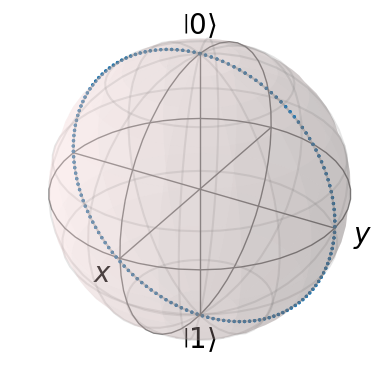

In [5]:
theta = Parameter('θ')
angs = np.linspace(0, 2*np.pi, 150)

qc = QuantumCircuit(1)
qc.h(0)
qc.p(theta, 0)
qc.h(0)
print(qc)

st_all = [Statevector.from_instruction(qc.assign_parameters([ang])) for ang in angs]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
b = Bloch(axes=ax)
b.point_color = ['tab:blue']
b.point_marker = ['o']
b.point_size =[2]

for st in st_all:
    v = state_to_bloch(st)
    b.add_points(v)
    
b.show()

Reference: [Parametrized Quantum Circuits](https://learn.qiskit.org/course/machine-learning/parameterized-quantum-circuits#parameterized-1-0)

   ┌───┐┌───────┐
q: ┤ H ├┤ Rz(θ) ├
   └───┘└───────┘
   ┌───┐┌───────┐┌───────┐
q: ┤ H ├┤ Rz(θ) ├┤ Rx(Φ) ├
   └───┘└───────┘└───────┘


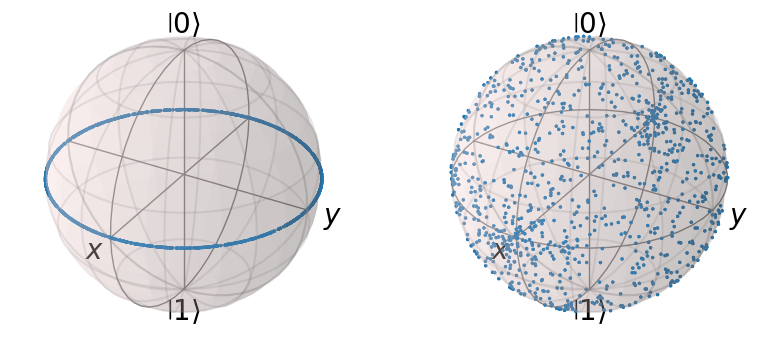

In [6]:
# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

print(qc_A)
print(qc_B)

# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()

Reference : [Expressibility and entangling capability of parameterized quantum circuits](https://arxiv.org/pdf/1905.10876.pdf)

<div><img src="paramQC.png" width="2000"/></div>

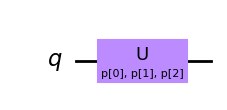

In [7]:
param = ParameterVector('p', 3)

ansatz = QuantumCircuit(1)
ansatz.u(*(param), 0)
ansatz.draw('mpl')

**Step 2. Build quantum circuits to estimate the expectation value of the hamiltonian, $\langle H\rangle = \langle X\rangle$**.

The expectation value of an operator, $O$, with respect to a state $|\psi\rangle$, can be calculated as follows. 

$\langle O\rangle = \Sigma_{i=1}^{n}λ_{i}|\langle e_{i}|\psi\rangle|^{2}, ~~~ $where $O = \Sigma_{i=1}^{n}λ_{i}|e_{i}\rangle$.

The value $|\langle e_{i}|\psi\rangle|^{2}$ can be obtained by measuring a quantum circuit producing $|\psi\rangle$ in the eigenbasis of $O$. The appropriate post rotation gates are applied to measure a circuit in the eigenbasis of $O$ as measurement is possible only in the computational basis on IBM Quantum systems.

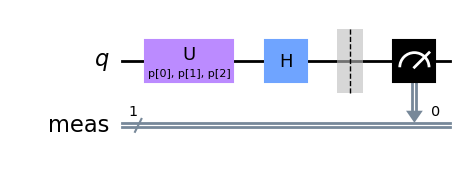

In [8]:
## Circuits

meas_x = QuantumCircuit(1)
meas_x.h(0)

qc_x = ansatz.compose(meas_x)
qc_x.measure_all()
qc_x.draw('mpl')

**Step 3. Optimization**

In [9]:
def cost(param_vals):
    
    bc_x = qc_x.assign_parameters(param_vals) 
    counts = backend.run(bc_x, shots=100000).result().get_counts()
    vals = sampled_expectation_value(counts, 'Z') 
    cost = 2*vals
    cost_all.append(cost)
    
    return cost    

In [10]:
cost_all = []
param_init = 2*np.pi*np.random.rand(ansatz.num_parameters)
ret1qx = minimize(cost, param_init, method='COBYLA')

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.99984
       x: [ 7.843e+00  3.145e+00  4.261e+00]
    nfev: 49
   maxcv: 0.0


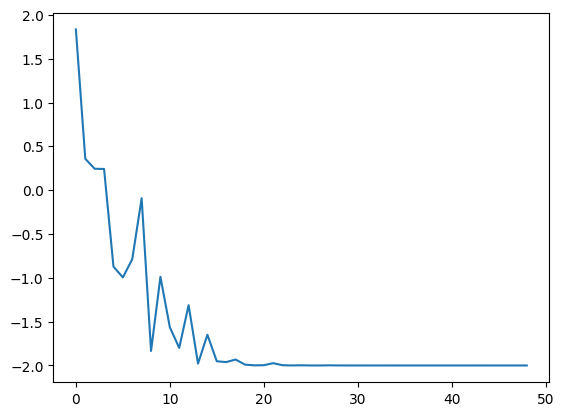

In [11]:
print(ret1qx)
plt.plot(cost_all);

#### Results

In [12]:
print('The true ground state energy of H : {}'.format(np.round(Eg, 3)))
print('The estimated ground state energy of H : {}'.format(np.round(ret1qx.fun, 3)))

The true ground state energy of H : -2.0
The estimated ground state energy of H : -2.0


###  Ex2. Estimate the ground state energy for the given hamilonian, $H = 2X + Y + Z$.

#### Exact Answer

In [13]:
sX, sY, sZ = np.array([[0, 1],[1, 0]]), np.array([[0, -1j],[1j, 0]]), np.array([[1, 0], [0, -1]])
H = sZ + 2*sX + sY
eigvals, eigvecs = la.eig(H)
Eg = np.min(eigvals)

print('The true ground state energy of H : {}'.format(np.round(Eg, 3)))

The true ground state energy of H : (-2.449-0j)


#### Using VQE 

**Step 1. Ansatz - State Preparation**

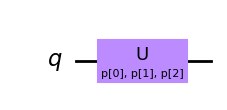

In [14]:
## your code goes here
param = ParameterVector('p', 3)

ansatz = QuantumCircuit(1)
ansatz.u(*(param), 0)
ansatz.draw('mpl')

**Step 2. Build quantum circuits to estimate the expectation value of the hamiltonian, $\langle H\rangle = 2\langle X\rangle + \langle Y\rangle + \langle Z\rangle$**.
- Build the circuits for post rotation and add them to the ansatz from step 1. 

In [15]:
## Circuits

# for <X>
meas_x = QuantumCircuit(1)
meas_x.h(0)

# for <Y>
meas_y = QuantumCircuit(1)
meas_y.sdg(0)
meas_y.h(0)

# for <Z>
meas_z = QuantumCircuit(1)

# all circuits
qc_x = ansatz.compose(meas_x)
qc_y = ansatz.compose(meas_y)
qc_z = ansatz.compose(meas_z)

qc_all = [qc_x, qc_y, qc_z]

for qc in qc_all:
    qc.measure_all()

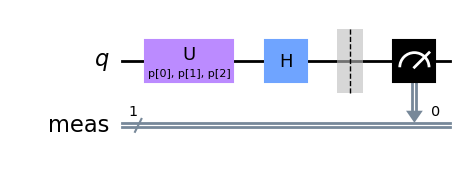

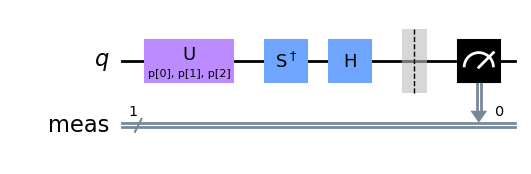

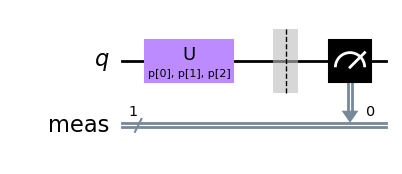

In [16]:
for k in range(3):
    display(qc_all[k].draw('mpl'))

**Step 3. Optimization**

In [17]:
def cost(param_vals):
    
    bc_all = [qc.assign_parameters(param_vals) for qc in qc_all]
    counts_all = backend.run(bc_all, shots=100000).result().get_counts()
    vals_qc = [sampled_expectation_value(counts, 'Z') for counts in counts_all]
    # cost for '2X + Y + Z'
    cost = 2*vals_qc[0]+ vals_qc[1] + vals_qc[2]
    cost_all.append(cost)
    
    return cost    

In [18]:
cost_all = []
param_init = 2*np.pi*np.random.rand(ansatz.num_parameters)
ret1q = minimize(cost, param_init, method='COBYLA')

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.44722
       x: [ 2.038e+00  3.602e+00  3.022e+00]
    nfev: 46
   maxcv: 0.0


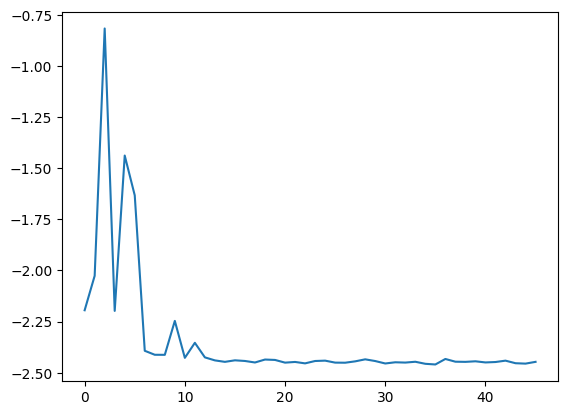

In [19]:
print(ret1q)
plt.plot(cost_all);

#### Results

In [20]:
print('The true ground state energy of H : {}'.format(np.round(Eg, 3)))
print('The estimated ground state energy of H : {}'.format(np.round(ret1q.fun, 3)))

The true ground state energy of H : (-2.449-0j)
The estimated ground state energy of H : -2.447


### Ex3. Estimate the ground state energy for the given hamilonian, $H = XX + YY + ZZ$, through VQE.

#### Exact Answer

In [21]:
H2q = np.kron(sX, sX) + np.kron(sY, sY) + np.kron(sZ, sZ)
eigvals, eigvecs = la.eig(H2q)
Eg = np.min(eigvals)

Eg = np.min(eigvals)
print('The true ground state energy of H : {}'.format(np.round(Eg, 3)))

The true ground state energy of H : (-3+0j)


#### Using VQE 

**Step 1. Ansatz**
 - Use [EfficientSU2](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html#qiskit.circuit.library.EfficientSU2)

In [22]:
from qiskit.circuit.library import EfficientSU2

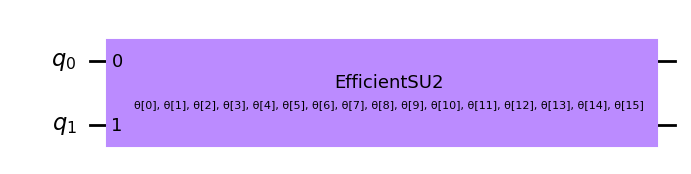

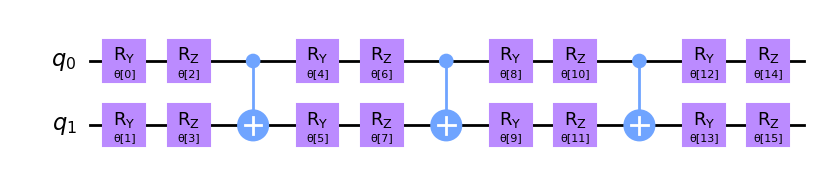

In [23]:
ansatz2q = EfficientSU2(2) 
display(ansatz2q.draw('mpl'))
display(ansatz2q.decompose().draw('mpl'))

**Step 2. Build quantum circuits to estimate the expectation value of the hamiltonian, $\langle H\rangle = \langle XX\rangle + \langle YY\rangle + \langle ZZ\rangle$**
- Build the circuits for post rotation and add them to the ansatz from step 1. 

In [24]:
# circuits
meas_xx = QuantumCircuit(2)
meas_xx.h(range(2))

meas_yy = QuantumCircuit(2)
meas_yy.sdg(range(2))
meas_yy.h(range(2))

meas_zz = QuantumCircuit(2)

circ_all = []
for qc in [meas_xx, meas_yy, meas_zz]:
    circ = ansatz2q.compose(qc)
    circ.measure_all()
    circ_all.append(circ)

In [25]:
circ_all_trans = transpile(circ_all, backend)

**Step 3. Optimization**
- Define a proper cost function
- Estimate the minimum energy by minimizing the cost function

In [26]:
def cost2q(param_vals):
    
    bc_all = [qc.assign_parameters(param_vals) for qc in circ_all_trans]
    counts_all = backend.run(bc_all, shots=100000).result().get_counts()
    vals_qc = [sampled_expectation_value(counts, 'ZZ') for counts in counts_all]
    # cost for 'XX + YY + ZZ'
    cost = sum(vals_qc)
    cost2q_all.append(cost)
    
    return cost  

In [27]:
cost2q_all = []
param_init = 2*np.pi*np.random.rand(ansatz2q.num_parameters)
ret2q = minimize(cost2q, param_init, method='COBYLA')

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.99986
       x: [ 3.035e+00  9.485e-01 ...  1.594e+00  1.269e+00]
    nfev: 198
   maxcv: 0.0


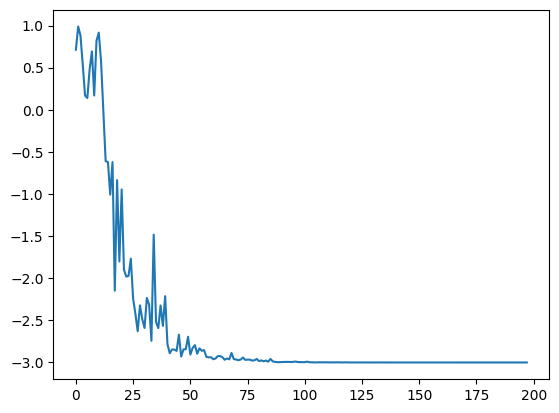

In [28]:
print(ret2q)
plt.plot(cost2q_all);

#### Results

In [29]:
## your code goes here
print('The true ground state energy of H : {}'.format(np.round(Eg, 3)))
print('The estimated ground state energy of H : {}'.format(np.round(ret2q.fun, 3)))

The true ground state energy of H : (-3+0j)
The estimated ground state energy of H : -3.0


## Part 2. With noise

In [31]:
from qiskit_ibm_provider import IBMProvider

In [32]:
prov = IBMProvider()
prov.backends()

[<IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_algiers')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibm_auckland')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_seattle')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

In [33]:
device = prov.get_backend('ibmq_lima')
noiseSim = AerSimulator().from_backend(device)

In [34]:
def cost2q(param_vals):
    
    bc_all = [qc.assign_parameters(param_vals) for qc in circ_all_trans]
    counts_all = noiseSim.run(bc_all, shots=100000).result().get_counts()
    vals_qc = [sampled_expectation_value(counts, 'ZZ') for counts in counts_all]
    cost = sum(vals_qc)
    cost2q_all.append(cost)
    
    return cost  

In [35]:
ansatz2q = EfficientSU2(2) 

meas_xx = QuantumCircuit(2)
meas_xx.h(range(2))

meas_yy = QuantumCircuit(2)
meas_yy.sdg(range(2))
meas_yy.h(range(2))

meas_zz = QuantumCircuit(2)

circ_all = []
for qc in [meas_xx, meas_yy, meas_zz]:
    circ = ansatz2q.compose(qc)
    circ.measure_all()
    circ_all.append(circ)
    
circ_all_trans = transpile(circ_all, noiseSim, optimization_level=3)

/Users/hwajungkang/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/hwajungkang/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [36]:
cost2q_all = []
param_init = 2*np.pi*np.random.rand(ansatz2q.num_parameters)
ret2q_noise = minimize(cost2q, param_init, method='COBYLA')

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.6936999999999998
       x: [ 2.202e+00  3.782e+00 ...  5.975e+00  3.173e+00]
    nfev: 198
   maxcv: 0.0


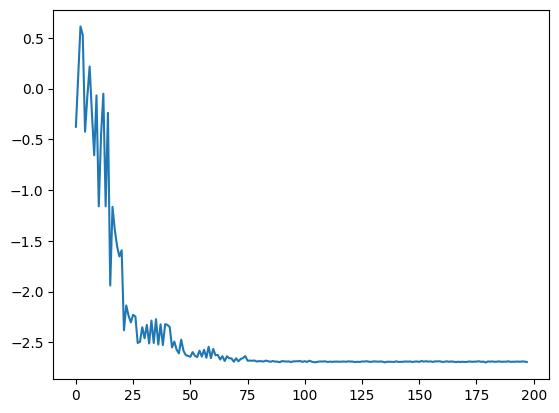

In [37]:
print(ret2q_noise)
plt.plot(cost2q_all);

In [40]:
print('The true ground state energy of H : {}'.format(np.round(Eg, 3)))
print('The estimated ground state energy of H without noise: {}'.format(np.round(ret2q.fun, 3)))
print('The estimated ground state energy of H in the presence of noise : {}'.format(np.round(ret2q_noise.fun, 3)))

The true ground state energy of H : (-3+0j)
The estimated ground state energy of H without noise: -3.0
The estimated ground state energy of H in the presence of noise : -2.694


In [41]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright